In [1]:
# The goal of this nb is to create a ML model to predict the expected loss (for the insurance company) given an individual and their subsequent characteristics such as age, sex, smoking, etc. 

# ExpAmt fields – these values represent the expected claim amounts for the policy year based upon certain mortality tables (such as the 2015 vbt, for example).
    # The values depend upon various factors such as issue age, sex, smoker/non-smoker, and duration.
    # For example, suppose we had a policy issued on a 20-year-old male non-smoker that is now in its 10th policy year (duration = 10, and the insured is now 30 years old).
    # According to the 2015 vbt table, the expected death rate for such a person is 0.44 per 1000; said differently, you could say that such an individual has a 0.44/1000 = 0.00044 probability of dying that year.
    # If the policy were for 500,000, then our expected claim amount for the policy year would be 500,000 * 0.44 / 1000 = 220.
    # As you might expect, older individuals will typically have a higher probability of dying and thus higher expected claim amounts for the same policy size.
    # Similarly, different smoker status and/or sex will affect the expected claim amounts.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import math
import seaborn as sb

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [3]:
# Bring in Data and Select Input and Output variable(s)

df = pd.read_csv('Mort2020.csv')

X = df[['CvgSexCode',
        'CvgIssueAge',
        'Duration',
        'AttainedAge',
        'MortExposureAmt',
        'PivotTobaccoCode',
        '2015vbtExpAmt',
        '2015vbtExpNum'
        ]]


C:\Users\oakle\AppData\Local\Temp\ipykernel_15660\388134165.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Mort2020.csv')


In [4]:
X.reset_index(inplace=True,drop=True)

for row in X.itertuples():


    index = row[0]
    
    # Convert sex_char to num
    gender = row.CvgSexCode
    if gender == 'M':
        X.at[index,'CvgSexCode'] = 0
    else: X.at[index,'CvgSexCode'] = 1

    # Convert smoker to Bool
    smoker = str(getattr(row,'PivotTobaccoCode'))
    if smoker == 'S':
        X.at[index,'PivotTobaccoCode'] = True
    else: X.at[index,'PivotTobaccoCode'] = False

In [5]:

y = df['MortDecAmt']

In [6]:
X

,CvgSexCode,CvgIssueAge,Duration,AttainedAge,MortExposureAmt,PivotTobaccoCode,2015vbtExpAmt,2015vbtExpNum
0,0,33,20,52,100000.000000,True,483.000000,0.0032
1,1,53,20,72,5416.666667,False,53.895833,0.0008
2,1,52,20,71,14166.666670,False,125.091667,0.0014
3,0,28,20,47,16500.000000,True,54.450000,0.0008
4,0,52,20,71,8041.666667,True,255.403333,0.0026
...,...,...,...,...,...,...,...,...
810553,0,26,15,40,250000.000000,False,192.500000,0.0000
810554,0,36,13,48,350000.000000,True,1008.000000,0.0000
810555,0,36,14,49,200000.000000,False,254.000000,0.0000
810556,1,44,12,55,25000.000000,False,41.000000,0.0000


In [9]:
# Designate 80% of Data for training the model and 20% for Testing/Validation
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=.8,test_size=.2,random_state=50)

# ------------------- FROM THIS POINT ON ALL TRAIN AND TEST DATA MUST BE SEPARATE. --------------------------------

In [29]:
# Handle Outliers of 'MortExposureAmt', '2015vbtExpAmt', and '2015vbtExpNum' for Train and Test individually
# DO NOT MIX TRAIN AND TEST DATA

# Use this link for references: https://neuraldatascience.io/5-eda/data_cleaning.html

#
#

<function matplotlib.pyplot.show(close=None, block=None)>

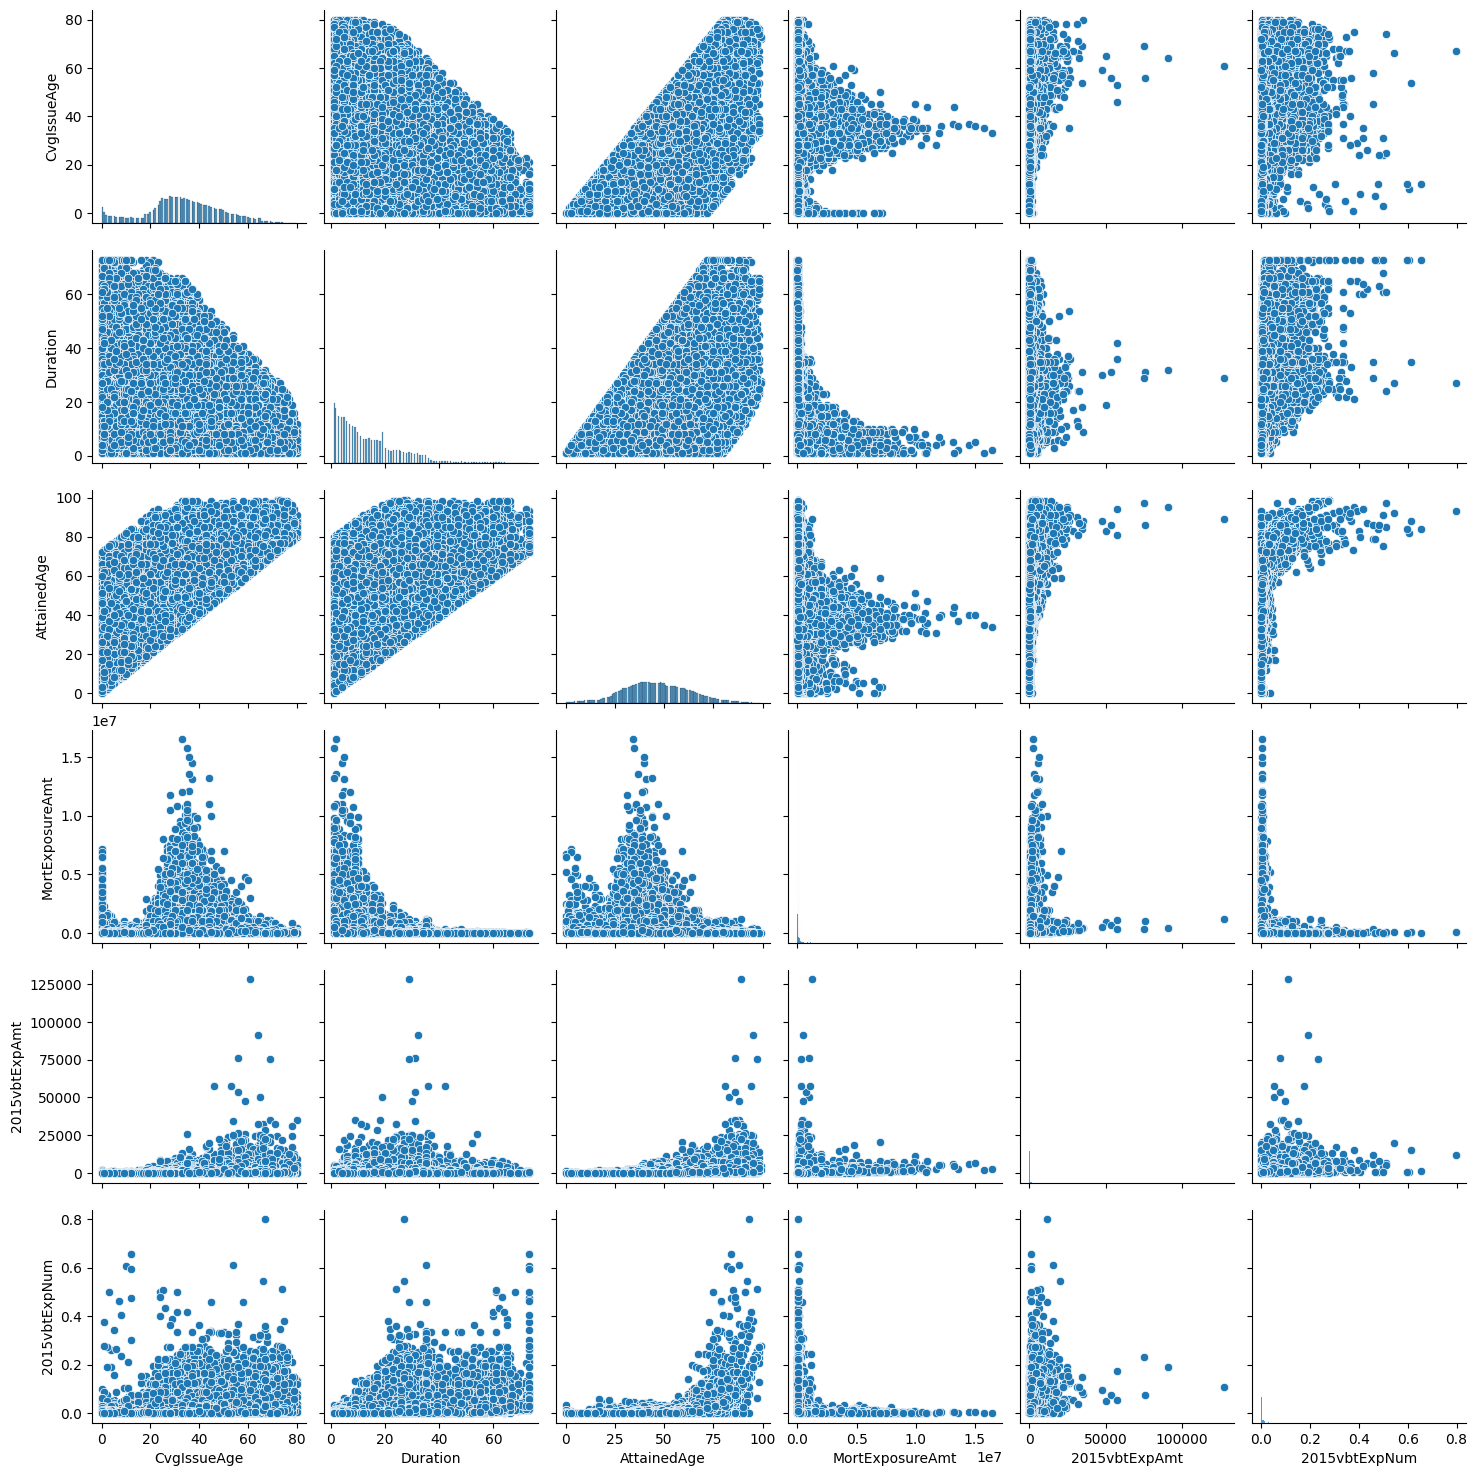

In [28]:
# Create Pairplot to check for weird Data

sb.pairplot(data=(X_test.drop(columns=['CvgSexCode','PivotTobaccoCode'])))
plt.show

In [25]:
# Create Multicollinearity Matrix
# If num > .90 , Column x Row are collinear

Xy_collin = pd.concat([y_train , X_train], axis =1)

collin = StandardScaler()

collin_fit = collin.fit(Xy_collin)

df_collin = pd.DataFrame(collin_fit.transform(Xy_collin))
df_collin.columns = Xy_collin.columns
df_collin.index = Xy_collin.index

corr_m = df_collin.corr(method='pearson')

corr_m_abs = corr_m.abs()
corr_m_upper = corr_m_abs.where(
    np.triu(np.ones(corr_m_abs.shape), k=1).astype(bool))

corr_m_upper

,MortDecAmt,CvgSexCode,CvgIssueAge,Duration,AttainedAge,MortExposureAmt,PivotTobaccoCode,2015vbtExpAmt,2015vbtExpNum
MortDecAmt,NaN,0.014599,0.027033,0.013043,0.034130,0.006405,0.002637,0.077587,0.031852
CvgSexCode,NaN,NaN,0.011128,0.026756,0.029069,0.049053,0.104003,0.090086,0.034753
CvgIssueAge,NaN,NaN,NaN,0.263092,0.733787,0.008937,0.044885,0.237973,0.218327
Duration,NaN,NaN,NaN,NaN,0.462392,0.181885,0.085931,0.152090,0.420674
AttainedAge,NaN,NaN,NaN,NaN,NaN,0.119868,0.019260,0.325810,0.496887
MortExposureAmt,NaN,NaN,NaN,NaN,NaN,NaN,0.064021,0.216584,0.064474
PivotTobaccoCode,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004507,0.030111
2015vbtExpAmt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.442837
2015vbtExpNum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Test 1 - Histogram Gradient Boosted Trees



In [31]:
# Test 2 - MLP Regressor (Neural Network)



In [32]:
# Test 3 - Random Forest Regression

